In [72]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
import argparse
sys.path.append(os.environ.get("TAU_ACC_DIR"))
sys.path.append("/datapool/projects/nutau/scripts/")
import generate_electric_field_lookup_tables as efieldlut
import tau_Shower_Efield_Sim_lib as taulib
import event_histograms as ehist
%matplotlib inline

In [40]:
os.environ['TAU_ACC_ZHAIRES_DIR'] = "/datapool/projects/nutau/zhaires/mountain_top/npz_files/"

In [41]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
plt.rcParams['font.size']=12
plt.rcParams['legend.labelspacing'] = 0.1
cmap = matplotlib.cm.get_cmap('inferno')

In [42]:
class Arguments():
    def __init__(self, altitude, decay):
        self.altitude = altitude
        self.decay = decay

In [43]:
altitude =3.0
decay = 0.0
args = Arguments(altitude, decay)

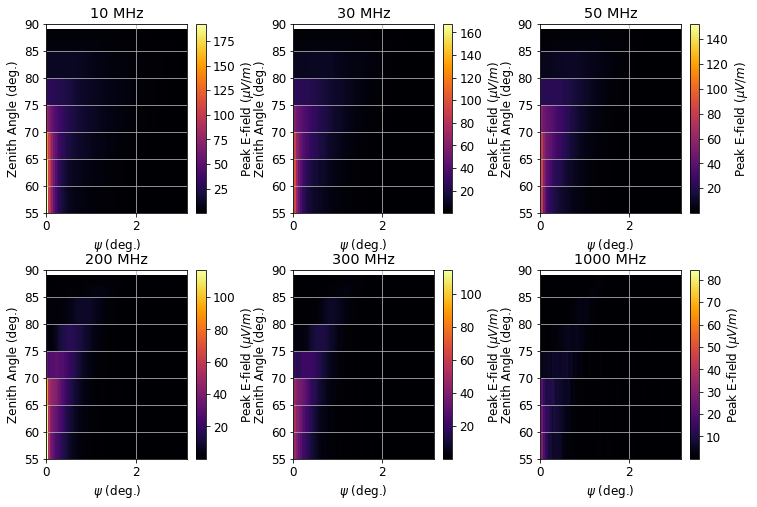

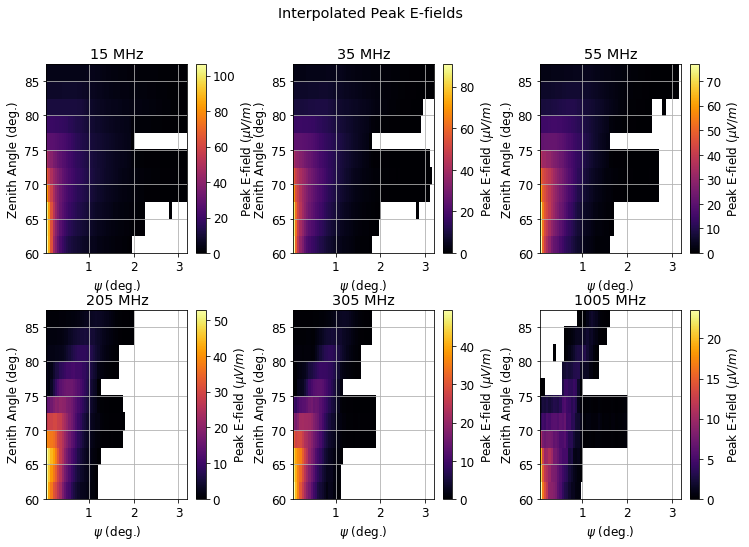

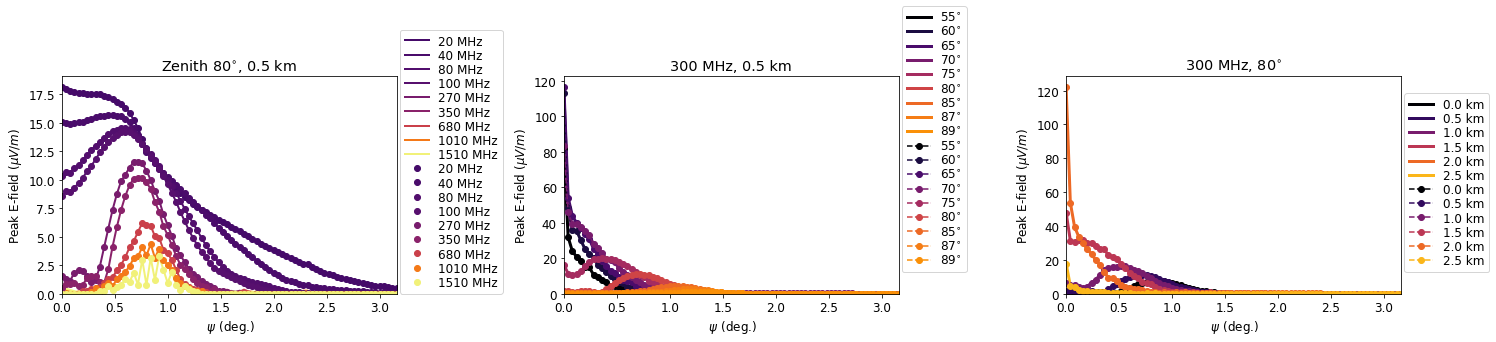

In [44]:
decay_list, zenith_list, psi_list, f_Lo_list, epeak_array, efield_interpolator_list = efieldlut.test_interpolator(args)

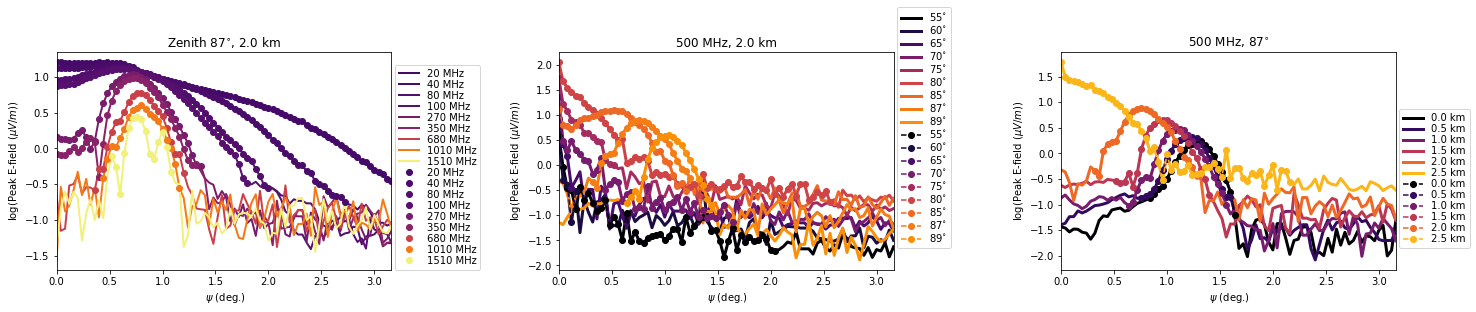

In [248]:
choose_ze=87
choose_f_Lo=500
choose_decay=2

efieldlut.compare_1d_plots(altitude, epeak_array,efield_interpolator_list,
                 decay_list, zenith_list, psi_list, f_Lo_list, 
         choose_decay, choose_ze, choose_f_Lo, log=True )


In [135]:
Gain_dB = 10.
Nphased = 10.
Z_A = 50.
Z_L = 50.
f_Lo = 200.
f_High = 1200.
log10_tau_energy = 17.
ground_elevation = 0.
decay = 2.1
zenith_angle = 88
Earth_radius = taulib.Earth_radius

In [219]:
def Voltage_interp(efield_interpolator_list, view_angle_deg, zenith_angle_deg, 
                   altitude, decay_altitude_km, f_Lo, f_High, 
                   log10_tau_energy, distance_decay_km,
		   Gain_dB,Z_A, Z_L, Nphased=1):
    # Lorentzian beam pattern based on 10-MHz filtered subbands of Harm's results
    # Returns electric field peak in V/m
  
    # Since the efields are stored in 10-MHz subbands
    # integrate over the range from f_Lo to f_High in 10-MHz bands
    Voltage = np.zeros(len(distance_decay_km))
    #E_field = 0.
    # TODO: Right now forcing the parameters outside the interpolation range to the edges
    # shoudl replace with extrapolation
    z = zenith_angle_deg.copy()
    v = view_angle_deg.copy()
    d = decay_altitude_km.copy()

    z[z>89.] = 89.
    z[z<55.] = 55.
    v[v<0.04] = 0.04
    v[v>3.16] = 3.16
    d[d>altitude-0.5] = altitude-0.5
    d[d<0] = 0.

   # these are the simulation arrays used to generate the lookup tables
    zenith_list = np.array([50, 55, 60, 65, 70, 75, 80, 85, 87, 89])
    decay_altitude_list = np.arange(0., altitude,0.5)

    # find the nearest neighbor for both the zenith angle at the exit point and the decay alttidue
    zhaires_sim_icethick = 0.0
    zhaires_sim_detector_altitude = altitude
    e_zhaires_tau_shower = 1e17
    r_zhaires_tau_shower = np.zeros(len(v))
    for i in range(len(v)): # loop over all the sims
    	i_ze = taulib.find_nearest(zenith_list, zenith_angle_deg[i])[0]
    	i_d  = taulib.find_nearest(decay_altitude_list, decay_altitude_km[i], lower_bound = 0)[0]
        nearest_zenith_angle = zenith_list[i_ze]
    	nearest_decay_altitude = decay_altitude_list[i_d]
    	r_zhaires_tau_shower[i] = taulib.get_distance_decay_to_detector_zenith_exit(zhaires_sim_icethick , nearest_decay_altitude,
									   zhaires_sim_detector_altitude, nearest_zenith_angle)

    df = 10.
    for freq in np.arange(f_Lo, f_High, df):
        i_f_Lo = int(round(freq / df - 1))
        # using the average frequency in the bin to calculate the voltage
        Voltage += taulib.E_to_V_signal(efield_interpolator_list[i_f_Lo](z,d,v), Gain_dB, (freq+df)/2., Z_A, Z_L, Nphased)

    # account for ZHAIReS sims only extending to 3.16 deg 
    Voltage[view_angle_deg>3.16] = Voltage[view_angle_deg>3.16]*np.exp( -(view_angle_deg[view_angle_deg>3.16]-0.)**2 / (2*3.16)**2)
    
    Voltage *= (r_zhaires_tau_shower / distance_decay_km )  # distance to tau decay point correction
    Voltage *= (pow(10, log10_tau_energy)/ e_zhaires_tau_shower) # Energy scaling
    return Voltage, r_zhaires_tau_shower, distance_decay_km, e_zhaires_tau_shower, pow(10, log10_tau_energy)

In [ ]:
z = 88
d = 0.0
df = 10
va = np.arange(0,1.5,0.04)
eps = np.zeros(len(va))
vps = np.zeros(len(va))
for j,v in enumerate(va):
    freqs = np.arange(f_Lo, f_High, df)
    epeaks = np.zeros(len(freqs))
    vpeaks = np.zeros(len(freqs))
    for i, freq in enumerate(freqs):
        i_f_Lo = int(round(freq/df - 1))
        epeaks[i] = efield_interpolator_list[i_f_Lo](z,d,v)
        vpeaks[i] = taulib.E_to_V_signal(efield_interpolator_list[i_f_Lo](z,d,v), Gain_dB, (freq+df)/2., Z_A, Z_L, Nphased)
        vps[j] += taulib.E_to_V_signal(efield_interpolator_list[i_f_Lo](z,d,v), Gain_dB, (freq+df)/2., Z_A, Z_L, Nphased)
    eps[j] = np.sum(epeaks[i])
    #vps[j] = np.sum(vpeaks[i])
    plt.figure(1)
    plt.plot(freqs, epeaks)
    plt.figure(2)
    plt.plot(freqs, vpeaks)

In [ ]:
plt.plot(va, eps)

In [ ]:
plt.plot(va,vps)

In [ ]:
decay_altitude = np.zeros(len(psi_list)) + decay
for z in [88]:#np.arange(88,89.25,0.25):
    zen = np.zeros(len(psi_list)) + z
    distance_decay_to_detector = taulib.get_distance_decay_to_detector(ground_elevation, 
                                   decay_altitude, altitude,
                                   zen, R_e=Earth_radius)
    Volts, r_zhaires_tau_shower, distance_decay_km, e_zhaires_tau_shower, tau_energy = Voltage_interp(efield_interpolator_list, psi_list, zen,
                                 altitude, decay_altitude, f_Lo, f_High, 
                                 log10_tau_energy, distance_decay_to_detector,
                                 Gain_dB, Z_A, Z_L, Nphased)
    plt.figure(1)
    plt.plot(psi_list, Volts, label=z)
    print(r_zhaires_tau_shower[0])
    plt.figure(3)
    plt.plot(psi_list, distance_decay_km)
    
plt.legend(loc=[1.01,0.1])

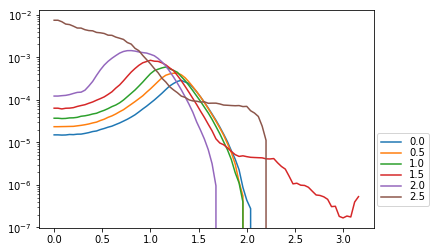

In [110]:
zen = np.zeros(len(psi_list)) + zenith_angle
for d in np.arange(0.,3.,0.5):
    decay_altitude = np.zeros(len(psi_list)) + d
    distance_decay_to_detector = taulib.get_distance_decay_to_detector(ground_elevation, 
                                   decay_altitude, altitude,
                                   zen, R_e=Earth_radius)
    Volts = Voltage_interp(efield_interpolator_list, psi_list, zen,
                                 altitude, decay_altitude, f_Lo, f_High, 
                                 log10_tau_energy, distance_decay_to_detector,
                                 Gain_dB, Z_A, Z_L, Nphased)
    plt.semilogy(psi_list, Volts, label=d)
plt.legend(loc=[1.01,0.1])

In [66]:
ddd = taulib.get_distance_decay_to_detector(ground_elevation, 
                                   decay_list, altitude,
                                   zenith_angle, R_e=Earth_radius)

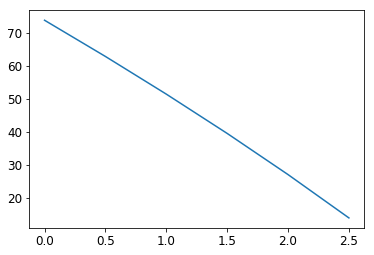

In [67]:
plt.plot(decay_list, ddd)

In [68]:
ddd = taulib.get_distance_decay_to_detector(ground_elevation, 
                                   decay, altitude,
                                   zenith_list, R_e=Earth_radius)

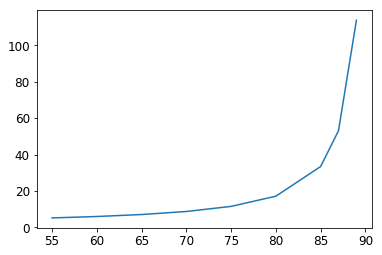

In [69]:
plt.plot(zenith_list, ddd)

In [74]:
os.environ['TAU_ACC_DET_DIR'] = '/datapool/projects/nutau/det_files/beacon/paper/'
events = ehist.NutauEvents(1, 17, 3, 0, 200, 1200, 10, 10, 
                           "mid", "std", 0, 5.0, filemode=2)

In [93]:
N = 10000
Volts = taulib.Voltage_interp(efield_interpolator_list, 
                              events.decay_view_angle[0:N], 
                              events.zenith_angle_decay[0:N],
                              altitude, 
                              events.decay_altitude[0:N], f_Lo, f_High, 
                              events.log10_tau_energy[0:N], 
                              events.dist_decay_to_detector[0:N],
                              Gain_dB, Z_A, Z_L, Nphased)

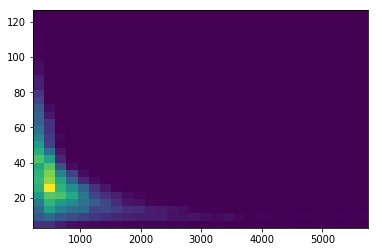

In [94]:
ret = plt.hist2d(Volts*1e6, events.dist_decay_to_detector[0:N],30)

(80, 89.82403905249595)

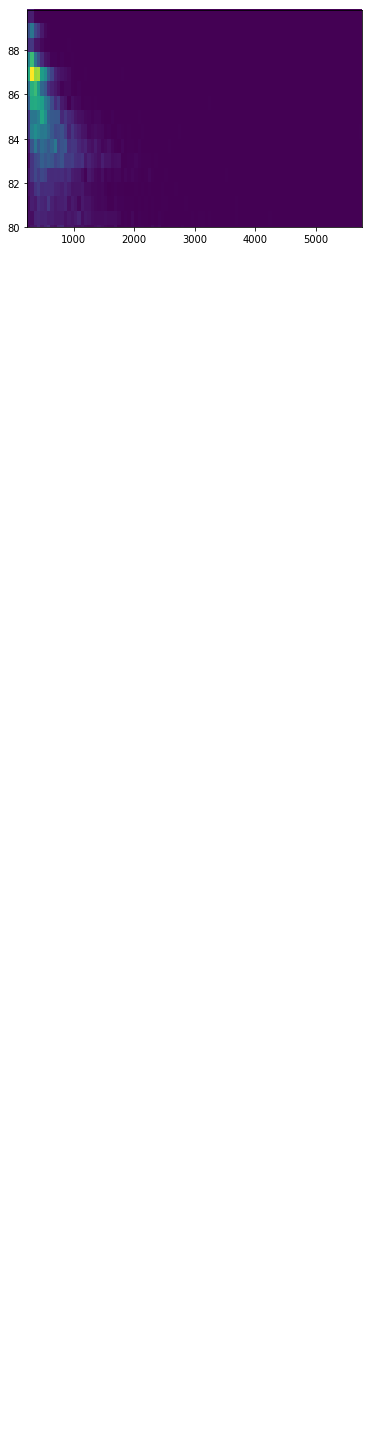

In [95]:
ret = plt.hist2d(Volts*1e6, events.zenith_angle_decay[0:N],100)
plt.ylim(80,)